
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh

____

# 🔴 **Import Libs**

In [3]:
!pip install torch==1.13.0 torchtext==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.0 MB/s eta 0:00:00


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim import SGD
import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader
from torch import optim
from torch.nn import functional as F

import tqdm
# import torchmetrics as tm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim


In [5]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
1.13.0+cu117
0.14.0


In [6]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 1.13.0+cu117
torchtext --> 0.14.0
tqdm --> 4.67.1


# 🔴 **Utils**

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [11]:
from datasets import load_dataset

wikitext2_dataset = load_dataset("wikitext", "wikitext-2-v1")

print(wikitext2_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [12]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

from datasets import load_dataset
wikitext2_dataset = load_dataset("wikitext", "wikitext-2-v1")

train_texts = wikitext2_dataset['train']['text']

vocab = build_vocab_from_iterator(yield_tokens(train_texts), specials=["<unk>", "<pad>", "<bos>", "<eos>"])

vocab.set_default_index(vocab["<unk>"])

print(f"Vocabulary size: {len(vocab)}")
print(f"Special tokens: {vocab.get_itos()[:4]}")

example_sentence = "This is an example sentence for testing."
tokenized_sentence = tokenizer(example_sentence)
indexed_sentence = vocab(tokenized_sentence)

print("Tokenized sentence:", tokenized_sentence)
print("Indexed sentence:", indexed_sentence)


Vocabulary size: 28785
Special tokens: ['<unk>', '<pad>', '<bos>', '<eos>']
Tokenized sentence: ['this', 'is', 'an', 'example', 'sentence', 'for', 'testing', '.']
Indexed sentence: [38, 26, 33, 620, 2131, 20, 3916, 6]


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [13]:
train_texts = wikitext2_dataset['train']['text']
validation_texts = wikitext2_dataset['validation']['text']
test_texts = wikitext2_dataset['test']['text']

def calculate_statistics(texts):
    """Calculate basic statistics for a dataset."""
    num_docs = len(texts)
    doc_lengths = [len(tokenizer(text)) for text in texts]
    total_words = sum(doc_lengths)
    avg_doc_length = np.mean(doc_lengths)
    max_doc_length = max(doc_lengths)
    min_doc_length = min(doc_lengths)

    return {
        "Number of Documents": num_docs,
        "Total Words": total_words,
        "Average Document Length": avg_doc_length,
        "Max Document Length": max_doc_length,
        "Min Document Length": min_doc_length,
    }

train_stats = calculate_statistics(train_texts)
validation_stats = calculate_statistics(validation_texts)
test_stats = calculate_statistics(test_texts)

stats_df = pd.DataFrame(
    [train_stats, validation_stats, test_stats],
    index=["Train", "Validation", "Test"]
)

print(stats_df)

            Number of Documents  Total Words  Average Document Length  \
Train                     36718      2049990                55.830655   
Validation                 3760       214417                57.025798   
Test                       4358       241859                55.497705   

            Max Document Length  Min Document Length  
Train                       696                    0  
Validation                  433                    0  
Test                        478                    0  


### 🟡 Analyze the most common and least common words in the dataset.

In [14]:
def count_word_frequencies(texts):

    word_counter = Counter()
    for text in texts:
        tokens = tokenizer(text)
        word_counter.update(tokens)
    return word_counter

all_texts = train_texts + validation_texts + test_texts

word_frequencies = count_word_frequencies(all_texts)

most_common_words = word_frequencies.most_common(10)  # Top 10 most common
least_common_words = word_frequencies.most_common()[:-11:-1]  # Bottom 10 least common

print("Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

print("\nLeast Common Words:")
for word, freq in least_common_words:
    print(f"{word}: {freq}")


Most Common Words:
the: 161565
,: 124587
.: 102203
<unk>: 81561
of: 69743
and: 61962
in: 54848
to: 48462
a: 44247
=: 35977

Least Common Words:
gallinae: 3
intergrades: 3
tuscola: 3
roundabouts: 3
zoromski: 3
forrester: 3
kreutzer: 3
chants: 3
sonatine: 3
mineurs: 3


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

uggestions for further exploration:

N-Gram Analysis: Identify frequent bigrams and trigrams.

Sentence Length Distribution: Visualize sentence lengths across the dataset.

Rare Words: Analyze hapax legomena (words appearing only once).

Vocabulary Coverage: Determine how many unique words cover 80% of the text.

Dataset Comparison: Compare statistics between train, validation, and test.

sentence lengths:

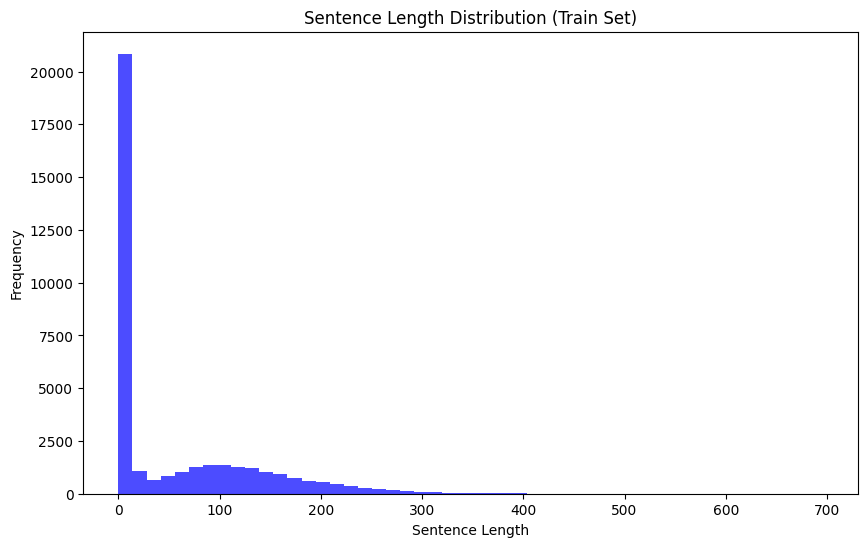

In [15]:
train_sentence_lengths = [len(tokenizer(text)) for text in train_texts]

# Plot a histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(train_sentence_lengths, bins=50, alpha=0.7, color='blue')
plt.title("Sentence Length Distribution (Train Set)")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [16]:
def data_process(raw_text_iter, batch_size, seq_len):

    tokens = [token for text in raw_text_iter for token in tokenizer(text)]

    token_indices = torch.tensor([vocab[token] for token in tokens], dtype=torch.long)

    usable_size = (token_indices.size(0) - 1) // (batch_size * seq_len) * (batch_size * seq_len)
    token_indices = token_indices[:usable_size + 1]
    inputs = token_indices[:-1].view(batch_size, -1)  # Shape: (B, N * L)
    targets = token_indices[1:].view(batch_size, -1)  # Shape: (B, N * L)

    inputs = inputs.unfold(1, seq_len, seq_len).permute(1, 0, 2)  # Shape: (N, B, L)
    targets = targets.unfold(1, seq_len, seq_len).permute(1, 0, 2)  # Shape: (N, B, L)

    return inputs, targets


In [17]:
batch_size = 16
seq_len = 32
train_inputs, train_targets = data_process(wikitext2_dataset['train']['text'], batch_size, seq_len)
val_inputs, val_targets = data_process(wikitext2_dataset['validation']['text'], batch_size, seq_len)
test_inputs, test_targets = data_process(wikitext2_dataset['test']['text'], batch_size, seq_len)

print(f"Train Inputs Shape: {train_inputs.shape}, Train Targets Shape: {train_targets.shape}")
print(f"Validation Inputs Shape: {val_inputs.shape}, Validation Targets Shape: {val_targets.shape}")
print(f"Test Inputs Shape: {test_inputs.shape}, Test Targets Shape: {test_targets.shape}")

Train Inputs Shape: torch.Size([4003, 16, 32]), Train Targets Shape: torch.Size([4003, 16, 32])
Validation Inputs Shape: torch.Size([418, 16, 32]), Validation Targets Shape: torch.Size([418, 16, 32])
Test Inputs Shape: torch.Size([472, 16, 32]), Test Targets Shape: torch.Size([472, 16, 32])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [18]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
        assert inputs.shape == targets.shape, "Inputs and targets must have the same shape."
        self.inputs = inputs
        self.targets = targets

  def __len__(self):

        return self.inputs.size(0)

  def __getitem__(self, idx):

        return self.inputs[idx], self.targets[idx]


In [19]:
train_dataset = LanguageModelDataset(train_inputs, train_targets)
val_dataset = LanguageModelDataset(val_inputs, val_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [20]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterating over the DataLoader
for batch_inputs, batch_targets in train_loader:
    print("Batch Inputs Shape:", batch_inputs.shape)
    print("Batch Targets Shape:", batch_targets.shape)
    break

Batch Inputs Shape: torch.Size([16, 16, 32])
Batch Targets Shape: torch.Size([16, 16, 32])


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [21]:
class LanguageModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src):

        embedded = self.dropout(self.embedding(src))  # Shape: (B, L, embedding_dim)

        lstm_out, _ = self.lstm(embedded)  # Shape: (B, L, hidden_dim)

        output = self.fc(lstm_out)  # Shape: (B, L, vocab_size)

        return output


In [22]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.2

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

example_input = torch.randint(0, vocab_size, (16, 32))
output = model(example_input)
print("Output shape:", output.shape)

Output shape: torch.Size([16, 32, 28785])


# 🔴 **Config**

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [25]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

num_epochs = 10

def calculate_accuracy(predictions, targets):

    _, predicted_indices = torch.max(predictions, dim=-1)
    correct = (predicted_indices == targets).float().sum()
    total = targets.numel()
    return correct / total

print(f"Optimizer: {optimizer}")
print(f"Loss function: {criterion}")


Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [39]:
import tqdm
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):

    model.train()
    loss_train = AverageMeter()
    metric.reset()
    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch:
                tepoch.set_description(f"Epoch {epoch}")

            inputs = inputs.permute(1, 0, 2).reshape(-1, inputs.size(-1)).to(device)  # (B, L)
            targets = targets.permute(1, 0, 2).reshape(-1, targets.size(-1)).to(device)  # (B, L)

            outputs = model(inputs)

            loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train.update(loss.item(), n=inputs.size(0))
            metric.update(outputs, targets)
            tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute())

    return model, loss_train.avg, metric.compute()


# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [52]:
def evaluate(model, test_loader, loss_fn, metric):

    model.eval()
    loss_eval = AverageMeter()
    metric.reset()

    with torch.inference_mode():
        for inputs, targets in test_loader:

            inputs = inputs.permute(1, 0, 2).reshape(-1, inputs.size(-1)).to(device)  # (B, L)
            targets = targets.permute(1, 0, 2).reshape(-1, targets.size(-1)).to(device)  # (B, L)

            outputs = model(inputs)

            loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            loss_eval.update(loss.item(), n=inputs.size(0))
            metric.update(outputs, targets)

    return loss_eval.avg, metric.compute()


# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [32]:
vocab_size = len(vocab)  # Size of the vocabulary
embedding_dim = 128      # Size of embedding vectors
hidden_dim = 256         # Number of hidden units in LSTM
num_layers = 2           # Number of LSTM layers
dropout_rate = 0.2

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.permute(1, 0, 2).reshape(-1, inputs.size(-1)).to(device)
targets = targets.permute(1, 0, 2).reshape(-1, targets.size(-1)).to(device)

with torch.no_grad():
    outputs = model(inputs)
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

print(f"Loss for untrained model: {loss.item():.4f}")



Loss for untrained model: 10.2655


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [33]:
subset_size = 100
small_train_loader = DataLoader(
    torch.utils.data.Subset(train_dataset, list(range(subset_size))),
    batch_size=16,
    shuffle=True,
)

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [35]:
class AccuracyMetric:
    def __init__(self):
        self.correct = 0
        self.total = 0

    def reset(self):
        self.correct = 0
        self.total = 0

    def update(self, outputs, targets):
        _, predicted = torch.max(outputs, dim=-1)
        self.correct += (predicted == targets).float().sum().item()
        self.total += targets.numel()

    def compute(self):
        return self.correct / self.total if self.total > 0 else 0
metric = AccuracyMetric()

In [41]:
num_epochs = 100

for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, small_train_loader, criterion, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 7/7 [00:00<00:00,  7.07batch/s, loss=7.19, metric=0.0631]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [46]:
num_epochs = 3
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f"Training with Learning Rate: {lr}")

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, train_loader, criterion, optimizer, metric, epoch)

    print(f"Finished training with Learning Rate: {lr}")
    print()

Training with Learning Rate: 0.001


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.19batch/s, loss=10.1, metric=0.0638]


Finished training with Learning Rate: 0.001

Training with Learning Rate: 0.01


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.18batch/s, loss=7.5, metric=0.0638]


Finished training with Learning Rate: 0.01

Training with Learning Rate: 0.1


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.17batch/s, loss=6.65, metric=0.127]

Finished training with Learning Rate: 0.1



### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [47]:
num_epochs = 3
best_lr = 0.01
weight_decays = [0.0, 1e-4, 1e-3, 1e-2]

for wd in weight_decays:
    print(f"Training with LR={best_lr}, WD={wd}")

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = SGD(model.parameters(), lr=best_lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
        model, loss, _ = train_one_epoch(model, train_loader, criterion, optimizer, metric, epoch)

    print(f"Finished training with LR={best_lr}, WD={wd}")


Training with LR=0.01, WD=0.0


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.21batch/s, loss=7.51, metric=0.0638]


Finished training with LR=0.01, WD=0.0
Training with LR=0.01, WD=0.0001


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.17batch/s, loss=7.49, metric=0.0638]


Finished training with LR=0.01, WD=0.0001
Training with LR=0.01, WD=0.001


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.18batch/s, loss=7.5, metric=0.0638]


Finished training with LR=0.01, WD=0.001
Training with LR=0.01, WD=0.01


Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.18batch/s, loss=7.57, metric=0.0638]

Finished training with LR=0.01, WD=0.01


### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





## 🟠 Main Loop

In [62]:
lr = 0.01
wd = 1e-4
num_epochs = 20

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
optimizer = optim.SGD(
    model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True
)

In [63]:
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [64]:
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [65]:
for epoch in range(num_epochs):

    model, loss_train, metric_train = train_one_epoch(
        model, train_loader, criterion, optimizer, metric, epoch
    )

    loss_valid, metric_valid = evaluate(model, val_loader, criterion, metric)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), "best_model.pt")
        best_loss_valid = loss_valid
        print("Model Saved!")

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train: Loss = {loss_train:.4f}, Metric = {metric_train:.4f}")
    print(f"Valid: Loss = {loss_valid:.4f}, Metric = {metric_valid:.4f}")
    print()

    epoch_counter += 1

100%|██████████| 251/251 [00:40<00:00,  6.18batch/s, loss=9.64, metric=0.0586]


Model Saved!
Epoch 1/20
Train: Loss = 9.6446, Metric = 0.0586
Valid: Loss = 8.0062, Metric = 0.0687



Epoch 1: 100%|██████████| 251/251 [00:41<00:00,  6.11batch/s, loss=7.82, metric=0.0638]


Model Saved!
Epoch 2/20
Train: Loss = 7.8222, Metric = 0.0638
Valid: Loss = 7.4181, Metric = 0.0687



Epoch 2: 100%|██████████| 251/251 [00:40<00:00,  6.13batch/s, loss=7.5, metric=0.0638]


Model Saved!
Epoch 3/20
Train: Loss = 7.4959, Metric = 0.0638
Valid: Loss = 7.2048, Metric = 0.0687



Epoch 3: 100%|██████████| 251/251 [00:41<00:00,  6.11batch/s, loss=7.33, metric=0.0638]


Model Saved!
Epoch 4/20
Train: Loss = 7.3343, Metric = 0.0638
Valid: Loss = 7.0725, Metric = 0.0687



Epoch 4: 100%|██████████| 251/251 [00:41<00:00,  6.06batch/s, loss=7.23, metric=0.0638]


Model Saved!
Epoch 5/20
Train: Loss = 7.2346, Metric = 0.0638
Valid: Loss = 6.9894, Metric = 0.0687



Epoch 5: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=7.17, metric=0.0638]


Model Saved!
Epoch 6/20
Train: Loss = 7.1678, Metric = 0.0638
Valid: Loss = 6.9292, Metric = 0.0687



Epoch 6: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=7.12, metric=0.0638]


Model Saved!
Epoch 7/20
Train: Loss = 7.1165, Metric = 0.0638
Valid: Loss = 6.8822, Metric = 0.0687



Epoch 7: 100%|██████████| 251/251 [00:40<00:00,  6.16batch/s, loss=7.07, metric=0.0679]


Model Saved!
Epoch 8/20
Train: Loss = 7.0728, Metric = 0.0679
Valid: Loss = 6.8382, Metric = 0.0747



Epoch 8: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=7.03, metric=0.0721]


Model Saved!
Epoch 9/20
Train: Loss = 7.0340, Metric = 0.0721
Valid: Loss = 6.8037, Metric = 0.0772



Epoch 9: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=7, metric=0.0758]


Model Saved!
Epoch 10/20
Train: Loss = 7.0016, Metric = 0.0758
Valid: Loss = 6.7733, Metric = 0.0854



Epoch 10: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.97, metric=0.0816]


Model Saved!
Epoch 11/20
Train: Loss = 6.9726, Metric = 0.0816
Valid: Loss = 6.7434, Metric = 0.0909



Epoch 11: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.94, metric=0.0885]


Model Saved!
Epoch 12/20
Train: Loss = 6.9448, Metric = 0.0885
Valid: Loss = 6.7131, Metric = 0.0965



Epoch 12: 100%|██████████| 251/251 [00:40<00:00,  6.16batch/s, loss=6.92, metric=0.0939]


Model Saved!
Epoch 13/20
Train: Loss = 6.9183, Metric = 0.0939
Valid: Loss = 6.6853, Metric = 0.1006



Epoch 13: 100%|██████████| 251/251 [00:40<00:00,  6.14batch/s, loss=6.89, metric=0.0983]


Model Saved!
Epoch 14/20
Train: Loss = 6.8932, Metric = 0.0983
Valid: Loss = 6.6577, Metric = 0.1050



Epoch 14: 100%|██████████| 251/251 [00:40<00:00,  6.14batch/s, loss=6.87, metric=0.102]


Model Saved!
Epoch 15/20
Train: Loss = 6.8690, Metric = 0.1021
Valid: Loss = 6.6351, Metric = 0.1091



Epoch 15: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.85, metric=0.105]


Model Saved!
Epoch 16/20
Train: Loss = 6.8457, Metric = 0.1053
Valid: Loss = 6.6119, Metric = 0.1115



Epoch 16: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.82, metric=0.108]


Model Saved!
Epoch 17/20
Train: Loss = 6.8231, Metric = 0.1080
Valid: Loss = 6.5865, Metric = 0.1175



Epoch 17: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.8, metric=0.111]


Model Saved!
Epoch 18/20
Train: Loss = 6.8010, Metric = 0.1107
Valid: Loss = 6.5638, Metric = 0.1202



Epoch 18: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.78, metric=0.113]


Model Saved!
Epoch 19/20
Train: Loss = 6.7795, Metric = 0.1126
Valid: Loss = 6.5409, Metric = 0.1229



Epoch 19: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=6.76, metric=0.116]


Model Saved!
Epoch 20/20
Train: Loss = 6.7583, Metric = 0.1161
Valid: Loss = 6.5234, Metric = 0.1271



## 🟠 Plot

🔰 Plot learning curves

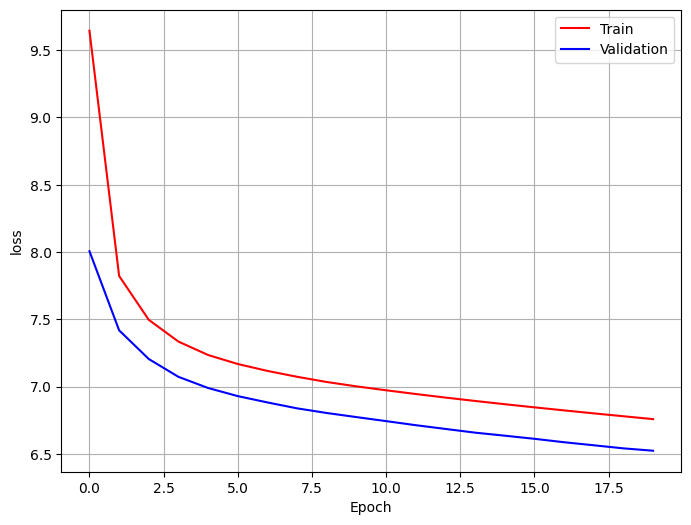

In [66]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [67]:
best_model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
best_model.load_state_dict(torch.load("best_model.pt"))

test_loss, test_metric = evaluate(best_model, test_loader, criterion, metric)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metric: {test_metric:.4f}")


Test Loss: 6.4704
Test Metric: 0.1273


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [86]:
import torch
import random

def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):

    tokens = tokenizer(prompt)
    indices = [vocab[token] if token in vocab else vocab["<unk>"] for token in tokens]

    input_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)

    model.eval()

    generated_tokens = tokens

    with torch.no_grad():
        for _ in range(max_seq_len):

            outputs = model(input_tensor)
            logits = outputs[:, -1, :]
            logits = logits / temperature
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            next_token_index = torch.multinomial(probabilities, num_samples=1).item()

            next_token = vocab.get_itos()[next_token_index]

            if next_token in ("<unk>", "<eos>"):
                break

            generated_tokens.append(next_token)

            input_tensor = torch.cat(
                [input_tensor, torch.tensor([[next_token_index]], dtype=torch.long).to(device)], dim=1
            )

    return " ".join(generated_tokens)



In [89]:
model_path = "best_model.pt"
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
model.load_state_dict(torch.load(model_path))

prompt = "My"
generated_text = generate(
    prompt, max_seq_len=10, temperature=1.0, model=model, tokenizer=tokenizer, vocab=vocab
)
print("Generated Text:")
print(generated_text)


Generated Text:
my freind and i , squadron back ' the intended of knowledge was which into
